In [2]:
%run /work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/duplications/

/work/clusterEvo/new_tests/eggNOG/duplications


In [3]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests
from ftplib import FTP
from time import sleep

In [4]:
few_duplications = pd.read_parquet('few_duplication_genes.parquet')
few_duplications.head()

,group_id,num_proteins,num_taxa,members,taxa
1217,arCOG00018,195,166,"1006006.Mcup_1244,1033806.HTIA_0702,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1219,arCOG00020,174,158,"1006006.Mcup_1524,1006006.Mcup_1889,1041930.Mt...","[1006006, 1006006, 1041930, 1042877, 1054217, ..."
1227,arCOG00028,108,103,"1041930.Mtc_2182,1070774.J07HN4v3_02653,109498...","[1041930, 1070774, 1094980, 1114856, 1114856, ..."
1228,arCOG00029,170,167,"1006006.Mcup_0319,1033806.HTIA_1327,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1230,arCOG00031,117,100,"1006006.Mcup_0023,1033806.HTIA_1326,1042877.GQ...","[1006006, 1033806, 1042877, 1056495, 1056495, ..."


In [5]:
representatives = few_duplications.query('num_taxa     == 168 & '
                                         'num_proteins == 168').iloc[0,3]

In [335]:
missing = []
for tmp in representatives.split(','):
    tmp = tmp.split('.')
    taxid = tmp[0]
    locus_tag = '.'.join(tmp[1:])
    
    if os.path.isfile(f'/work/clusterEvo/new_tests/eggNOG/duplications/genomes/{taxid}.gb.gz'):
        continue
    
    try:
        gene_id = re.search('<Id>(\d+)<\/Id>',
                            requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'
                                         'db=gene&'
                                        f'term={locus_tag}').text).group(1)
    except AttributeError:
        missing.append([taxid, locus_tag])
        continue
    finally:
        sleep(1)
        
    chr_accession = re.search('<Gene-source_src-str1>(\S+)</Gene-source_src-str1>',
                              requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
                                           'db=gene&'
                                           'retmode=xml&'
                                          f'id={gene_id}').text).group(1)
    
    sleep(1)
    
    try:
        assembly_acc = re.search('Assembly:\s+(\S+)\.\d+',
                                  requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
                                               'db=nuccore&'
                                               'retmode=text&'
                                               'rettype=gb&'
                                              f'id={chr_accession}').text).group(1)
    except AttributeError:
        missing.append([taxid, locus_tag])
        continue

    assembly_acc = assembly_acc.replace('GCF_', 'GCA')
    genome_folder = '/'.join([assembly_acc[pos:pos+3] for pos in range(0, len(assembly_acc), 3)])
    
    ftp = FTP('ftp.ncbi.nlm.nih.gov')       # connect to host, default port
    ftp.login()                             # user anonymous, passwd anonymous@
    ftp.cwd(f'genomes/all/{genome_folder}') # change into "debian" directory
    ftp.cwd(ftp.nlst()[0])
    
    for filename in ftp.nlst():
        if filename.endswith('gbff.gz'):
            print(filename, taxid)

            with open(f'/work/clusterEvo/new_tests/eggNOG/duplications/genomes/{taxid}.gb.gz', 'wb') as out:
                ftp.retrbinary(f'RETR {filename}', out.write)
            
            break
    
    sleep(1)
#     break

In [381]:
with cd('genomes/'):
    for filename in os.listdir('.'):
        if not filename.endswith('.gz'):
            continue

        subprocess.call(['gunzip', '-d', filename])

In [62]:
if not os.path.isfile('genomic_position_of_genes.parquet'):
    gene_positions = pd.DataFrame(columns=['taxid', 'replicon', 'start', 'end'])

    for filename in os.listdir('genomes/'):
        if not filename.endswith('.gb') or filename.startswith('.'):
            continue

        taxid = filename.replace('.gb', '')

        gb = SeqIO.parse(f'genomes/{filename}', 'gb')

        for entry in gb:

            for feat in entry.features:

                if feat.type != 'CDS' or 'locus_tag' not in feat.qualifiers:
                    continue

                locus_tag = feat.qualifiers['locus_tag'][0]
                gene_positions.loc[locus_tag] = [taxid,
                                                 entry.name,
                                                 feat.location.start.position, 
                                                 feat.location.end.position]
    #         break
    #     break

    gene_positions.to_parquet('genomic_position_of_genes.parquet')
else:
    gene_positions = pd.read_parquet('genomic_position_of_genes.parquet')

sampled_taxids = gene_positions.taxid.unique().astype(int)

In [68]:
wrong_taxids   = ['272557', '70601']
gene_positions = gene_positions.query('taxid not in @wrong_taxids').copy()
sampled_taxids = gene_positions.taxid.unique().astype(int)

In [7]:
replicon_sizes = pd.DataFrame(columns=['taxid', 'replicon', 'length'])
for filename in os.listdir('genomes/'):
    if not filename.endswith('.gb') or filename.startswith('.'):
        continue

    taxid = filename.replace('.gb', '')
    gb    = SeqIO.parse(f'genomes/{filename}', 'gb')
    
    for entry in gb:

        replicon_sizes = replicon_sizes.append(
            pd.Series(index=['taxid', 
                             'replicon', 
                             'length'],
                      data =[taxid,
                             entry.name,
                             len(entry)]),
            ignore_index=True
        )

In [8]:
recruited_seqs = []
for index, row in few_duplications.iterrows():
    recruited_seqs.extend(
        re.findall(f'(?:^|,)[^.]+\.([^,]+)', row.members)
    )

gene_positions = gene_positions.reindex(index=recruited_seqs).dropna(how='any')
gene_positions.drop_duplicates(inplace=True)

In [9]:
def get_distance_between_genes(gene_positions):
    
    gene_distances = pd.DataFrame(columns=['group1', 
                                           'group2', 
                                           'distance'])
    for (index1, row1), (index2, row2) in itertools.combinations(gene_positions.iterrows(), 2):

        dist_possibility1 = abs(row1.end - row2.start)
        dist_possibility2 = abs(row2.end - row1.start)

        if dist_possibility1 <= dist_possibility2:
            dist_between_pair = dist_possibility1
        else:
            dist_between_pair = dist_possibility2

        gene_distances = gene_distances.append(
            pd.Series(index=['group1', 
                             'group2', 
                             'distance'],
                      data =[index1,
                             index2,
                             dist_between_pair]),
            ignore_index=True
        )
    
    return(gene_distances)

In [10]:
eggNOG_trees = pd.read_csv('/work/clusterEvo/new_tests/eggNOG/2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])

eggNOG_trees = eggNOG_trees.reindex(index=few_duplications.group_id)

In [11]:
group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

table = {group:matrix.copy() for group, matrix in zip(group_ids, dist_matrices)}

In [12]:
#
# odr
odr_df = pd.read_parquet('odr_regression_Rsquared.parquet')

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
odr_df.set_index('group_pair', inplace=True)

#
# bray-curtis
braycurtis_df = pd.read_parquet('braycurtis_indices.parquet')

braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df.set_index('group_pair', inplace=True)

#
# combine
odr_df = odr_df.join(braycurtis_df.braycurtis)
odr_df['coevol_metric'] = odr_df.Rsquared * (odr_df.braycurtis**2)

odr_df.reset_index(drop=True, inplace=True)
odr_df.head()

,group1,group2,Rsquared,braycurtis,coevol_metric
0,arCOG00018,arCOG00020,0.826628,0.850949,0.598573
1,arCOG00018,arCOG00028,0.931708,0.679868,0.430654
2,arCOG00018,arCOG00029,0.757072,0.915068,0.633934
3,arCOG00018,arCOG00031,0.894787,0.634615,0.360364
4,arCOG00018,arCOG00034,0.910943,0.859551,0.673029


In [24]:
reduced_graph = odr_df.query('coevol_metric >= 0.8')

graph  = ig.Graph.TupleList(edges=reduced_graph[['group1', 
                                          'group2', 
                                          'coevol_metric']].itertuples(index=False, name=False), 
                            directed=False, 
                            weights=True)

In [25]:
clusters = graph.community_multilevel(weights='weight')

In [26]:
Counter(clusters.membership)

Counter({0: 14,
         1: 117,
         2: 113,
         3: 23,
         4: 36,
         5: 2,
         6: 3,
         7: 2,
         8: 2,
         9: 2,
         10: 2,
         11: 2,
         12: 4,
         13: 2,
         14: 2})

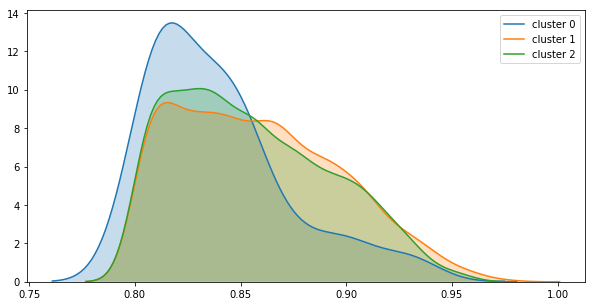

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(clusters.subgraph(0).es['weight'], label='cluster 0', shade=True, ax=ax)
sns.kdeplot(clusters.subgraph(1).es['weight'], label='cluster 1', shade=True, ax=ax)
sns.kdeplot(clusters.subgraph(2).es['weight'], label='cluster 2', shade=True, ax=ax)

In [30]:
subg = clusters.subgraph(1)

In [21]:
string = pd.read_parquet('few_duplications-string.parquet')

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

neighors     = string.query('neighborhood >= 700')
not_neighors = string.query('neighborhood <= 200')

In [29]:
neighors.head()

,group1,group2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,group_pair
2456,arCOG00495,arCOG00862,770,830,706,490,179,450,499,998,"(arCOG00862, arCOG00495)"
3482,arCOG00495,arCOG00914,709,0,279,489,0,450,499,965,"(arCOG00914, arCOG00495)"
13057,arCOG00644,arCOG01044,714,855,422,94,0,450,499,992,"(arCOG01044, arCOG00644)"
29725,arCOG00410,arCOG00412,808,612,0,474,499,450,499,993,"(arCOG00412, arCOG00410)"
47105,arCOG01001,arCOG04243,703,0,0,440,475,0,467,947,"(arCOG01001, arCOG04243)"


In [23]:
neighors.shape

(520, 11)

In [131]:
few_duplications.shape

(480, 5)

In [130]:
neighors.group1.value_counts()

arCOG04255    26
arCOG04254    25
arCOG04070    25
arCOG04243    24
arCOG04072    23
arCOG04067    22
arCOG04098    21
arCOG04097    20
arCOG04095    19
arCOG04092    18
arCOG01001    17
arCOG04091    17
arCOG04090    16
arCOG04087    15
arCOG01722    14
arCOG04240    13
arCOG04099    12
arCOG04096    11
arCOG04113    10
arCOG04094     9
arCOG00782     8
arCOG00779     7
arCOG02208     7
arCOG04274     6
arCOG00618     6
arCOG04241     6
arCOG00617     5
arCOG00785     5
arCOG00105     4
arCOG04338     4
              ..
arCOG01760     1
arCOG00112     1
arCOG01337     1
arCOG01320     1
arCOG04477     1
arCOG04465     1
arCOG01026     1
arCOG04185     1
arCOG01559     1
arCOG00102     1
arCOG04183     1
arCOG00493     1
arCOG03054     1
arCOG00869     1
arCOG01482     1
arCOG00862     1
arCOG04262     1
arCOG02701     1
arCOG01016     1
arCOG04288     1
arCOG01824     1
arCOG01594     1
arCOG04236     1
arCOG01530     1
arCOG00644     1
arCOG00641     1
arCOG00410     1
arCOG01983    

In [125]:
distances_between_single_copies    = []
distances_between_matching_pairs   = []
distances_between_unmatching_pairs = []

# for group1, group2 in [('arCOG00018', 'arCOG00035')]:
# for group1, group2 in itertools.combinations(subg.vs['name'], 2):
for index, row in neighors.iterrows():
    
    group1 = row.group1
    group2 = row.group2

    pair = (group1, group2)
    if odr_df.query('group1 in @pair and group2 in @pair').coevol_metric.squeeze() < 0.9:
#     string_query = string.query('group1 in @pair & '
#                                 'group2 in @pair')
#     if not string_query.shape[0] or string_query.neighborhood.squeeze() < 700:
        continue

    #################################################################################
    matrix1 = table[group1].copy()
    matrix2 = table[group2].copy()

    matrix1, taxa1, matrix2, taxa2 = balance_matrices(matrix1, 
                                                      matrix2, 
                                                      gene_sep='.')

    #################################################################################

    duplicated_taxa = set()

    tmp = few_duplications.query('group_id ==  @group1').squeeze()
    for taxa in tmp.taxa:
        if tmp.members.count(str(taxa)) > 1:
            duplicated_taxa.add(taxa)

    tmp = few_duplications.query('group_id ==  @group2').squeeze()
    for taxa in tmp.taxa:
        if tmp.members.count(str(taxa)) > 1:
            duplicated_taxa.add(taxa)

    duplicated_taxa.intersection_update(few_duplications.query('group_id == @group1').taxa.squeeze())
    duplicated_taxa.intersection_update(few_duplications.query('group_id == @group2').taxa.squeeze())

    duplicated_taxa.intersection_update(sampled_taxids)
        
#     if duplicated_taxa:
#         break
        
    #################################################################################
    
    for taxid in duplicated_taxa:
        group1_genes = re.findall(f'{taxid}\.([^,]+)',
                                  few_duplications.query('group_id == @group1').members.squeeze())
        group2_genes = re.findall(f'{taxid}\.([^,]+)',
                                  few_duplications.query('group_id == @group2').members.squeeze())
        
    #################################################################################
    
        gene_distances = pd.DataFrame(columns=['gene1', 'gene2', 'distance'])
        for gene1, gene2 in zip(gene_positions.index.intersection(group1_genes),
                                gene_positions.index.intersection(group2_genes)):

            row1 = gene_positions.loc[gene1]
            row2 = gene_positions.loc[gene2]

            if row1.replicon != row2.replicon:
                gene_distances = gene_distances.append(
                    pd.Series(index=['gene1', 
                                     'gene2', 
                                     'distance'],
                              data =[gene1, 
                                     gene2, 
                                     replicon_sizes.query('replicon == @row1.replicon').length.squeeze() + \
                                     replicon_sizes.query('replicon == @row2.replicon').length.squeeze()]),
                    ignore_index=True
                )
                continue

            gene1_positions = sorted(row1[['start', 'end']].tolist())
            gene2_positions = sorted(row2[['start', 'end']].tolist())

            distance_possibilities = [abs(gene1_positions[1] - gene2_positions[0])]
            distance_possibilities.append(
                gene1_positions[0] + \
                (replicon_sizes.query('replicon == @row2.replicon').length.squeeze() - gene2_positions[1])
            )

            gene_distances = gene_distances.append(
                pd.Series(index=['gene1', 
                                 'gene2', 
                                 'distance'],
                          data =[gene1,
                                 gene2,
                                 np.min(distance_possibilities)]),
                ignore_index=True
            )

    #################################################################################
    
        selected_genes1 = taxa1.query(f'genome == "{taxid}"').gene
        selected_genes2 = taxa2.query(f'genome == "{taxid}"').gene
        
        for selected1, selected2 in zip(selected_genes1.tolist(), 
                                        selected_genes2.tolist()):
            distances_between_matching_pairs.extend(
                gene_distances.query('gene1 ==  @selected1 & '
                                     'gene2 ==  @selected2').distance.tolist()
            )
            distances_between_unmatching_pairs.extend(
#                 gene_distances.query('gene1 !=  @selected1 | '
#                                      'gene2 !=  @selected2').distance.tolist()
                gene_distances.query('(gene1 ==  @selected1 & gene2 !=  @selected2) | '
                                     '(gene1 !=  @selected1 & gene2 ==  @selected2)').distance.tolist()
            )
#         break

    #################################################################################

    single_copy_taxa = set(taxa1.genome.astype(int).tolist())
    single_copy_taxa.difference_update(duplicated_taxa)
    single_copy_taxa.intersection_update(sampled_taxids)

    for taxid in single_copy_taxa:
        gene1 = re.findall(f'{taxid}\.([^,]+)',
                           few_duplications.query('group_id == @group1').members.squeeze())[0]
        gene2 = re.findall(f'{taxid}\.([^,]+)',
                           few_duplications.query('group_id == @group2').members.squeeze())[0]
            
        row1 = gene_positions.loc[gene1]
        row2 = gene_positions.loc[gene2]

        if row1.replicon != row2.replicon:
            continue

        gene1_positions = sorted(row1[['start', 'end']].tolist())
        gene2_positions = sorted(row2[['start', 'end']].tolist())

        distance_possibilities = [abs(gene1_positions[1] - gene2_positions[0])]
        distance_possibilities.append(
            gene1_positions[0] + \
            (replicon_sizes.query('replicon == @row2.replicon').length.squeeze() - gene2_positions[1])
        )
        
        distances_between_single_copies.append( np.min(distance_possibilities) )

#     break

In [105]:
len(distances_between_single_copies), np.mean(distances_between_single_copies)

(39340, 339611.4407981698)

In [106]:
len(distances_between_matching_pairs), np.mean(distances_between_matching_pairs)

(107, 257126.58878504674)

In [107]:
len(distances_between_unmatching_pairs), np.mean(distances_between_unmatching_pairs)

(231, 366128.9956709957)

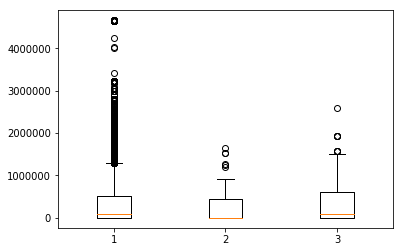

In [101]:
plt.boxplot([distances_between_single_copies,
             distances_between_matching_pairs,
             distances_between_unmatching_pairs]);

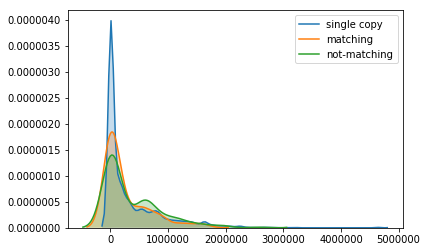

In [103]:
fig, ax = plt.subplots()

sns.kdeplot(distances_between_single_copies,    label='single copy',  shade=True, ax=ax)
sns.kdeplot(distances_between_matching_pairs,   label='matching',     shade=True, ax=ax)
sns.kdeplot(distances_between_unmatching_pairs, label='not-matching', shade=True, ax=ax);

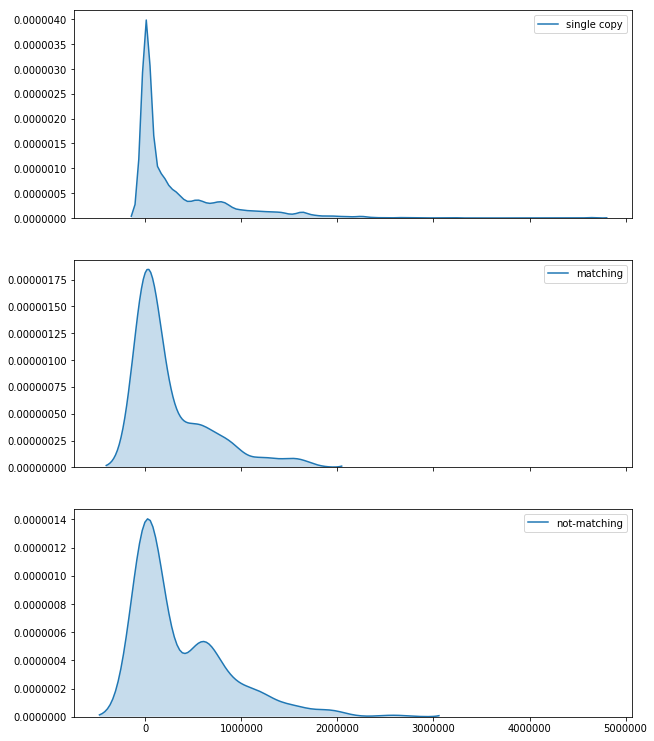

In [114]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 13))

sns.kdeplot(distances_between_single_copies,    label='single copy',  shade=True, ax=axs[0])
sns.kdeplot(distances_between_matching_pairs,   label='matching',     shade=True, ax=axs[1])
sns.kdeplot(distances_between_unmatching_pairs, label='not-matching', shade=True, ax=axs[2]);

In [122]:
from scipy.stats import ttest_ind, mannwhitneyu

In [ ]:
ttest_ind()

In [124]:
mannwhitneyu(distances_between_single_copies, 
             distances_between_unmatching_pairs)

MannwhitneyuResult(statistic=4316271.0, pvalue=0.09439425040966437)

In [828]:
odr_df.query('Rsquared >= 0.99').shape

(244, 5)

In [1055]:
neighbors = set(string.query('(group1 == "arCOG01001" | group2 == "arCOG01001") & '
                             'neighborhood >= 700')[['group1', 'group2']].T.agg(frozenset).tolist())

In [1056]:
coevolving = set(odr_df.query('(group1 == "arCOG01001" | group2 == "arCOG01001") & '
                              'coevol_metric >= 0.9')[['group1', 'group2']].T.agg(frozenset).tolist())

In [1057]:
neighbors.intersection(coevolving)

{frozenset({'arCOG01001', 'arCOG04097'})}

In [1069]:
group1, group2 = 'arCOG01001', 'arCOG04097'

matrix1  = table[group1].copy()
matrix2  = table[group2].copy()

# assess_coevolution(matrix1.copy(),
#                    matrix2.copy(),
#                    gene_sep='.')

In [1070]:
regex = re.compile('^(\d+?)\.(.*)$')

tmp_taxa = []
for index in matrix1.index:
    genome, gene = re.search(regex, index).groups()
    tmp_taxa.append([index, genome, gene])

taxa1 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                     data=tmp_taxa)

tmp_taxa = []
for index in matrix2.index:
    genome, gene = re.search(regex, index).groups()
    tmp_taxa.append([index, genome, gene])

taxa2 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                     data=tmp_taxa)

shared_genomes = np.intersect1d(taxa1.genome.unique(), 
                                taxa2.genome.unique())

taxa1 = taxa1[taxa1.genome.isin(shared_genomes)]
taxa2 = taxa2[taxa2.genome.isin(shared_genomes)]

In [1071]:
len(shared_genomes)

168

In [1072]:
taxa1_frequency = taxa1.genome.value_counts() 
taxa2_frequency = taxa2.genome.value_counts()

if not taxa1.genome.is_unique or not taxa2.genome.is_unique:

#     taxa1_frequency = Counter(taxa1.genome) 
#     taxa2_frequency = Counter(taxa2.genome)

    for genome in shared_genomes:
        genome1_count = taxa1_frequency[genome]
        genome2_count = taxa2_frequency[genome]
        
#         print(genome, genome1_count, genome2_count)

        if genome1_count > 1:
            print(genome, genome1_count, genome2_count)
            #
            # one of the matrices must be traversed in the inversed order to make sure an 
            #     all VS all combination is obtained. That is the reason of the "iloc[::-1]"
            #     during the querying
            tmp_df = taxa2.iloc[::-1].query('genome == @genome').copy()
            for _ in range(genome1_count - 1):
                for index, row in tmp_df.iterrows():
                    tmp_row = row.copy()
                    tmp_row.taxon += f'|{_}'
                    taxa2      = taxa2.append(tmp_row, ignore_index=True)

                    reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                    matrix2[    tmp_row.taxon] = matrix2[    reference_name]
                    matrix2.loc[tmp_row.taxon] = matrix2.loc[reference_name]


        if genome2_count > 1:
            print(genome, genome1_count, genome2_count)
            #
            # as we queried the other matrix in the reverse order, we traverse this one regularly
            tmp_df = taxa1.query('genome == @genome').copy()
            for _ in range(genome2_count - 1):
                for index, row in tmp_df.iterrows():
                    tmp_row = row.copy()
                    tmp_row.taxon += f'|{_}'
                    taxa1 = taxa1.append(tmp_row, ignore_index=True)

                    reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                    matrix1[    tmp_row.taxon] = matrix1[    reference_name]
                    matrix1.loc[tmp_row.taxon] = matrix1.loc[reference_name]

taxa1.sort_values('genome', inplace=True)
taxa2.sort_values('genome', inplace=True)

taxa1.reset_index(drop=True, inplace=True)
taxa2.reset_index(drop=True, inplace=True)

1041930 2 1
1131266 1 2
29540 2 1
304371 2 1
351160 2 1
868131 2 1
877455 2 1


In [1073]:
group1, group2

('arCOG01001', 'arCOG04097')

In [1024]:
with open(f'trees_to_check/{group1}.nwk', 'w') as out:
    out.write(eggNOG_trees.loc[group1, 'tree'])

In [1074]:
taxa1.query('genome == "1041930"')

,taxon,genome,gene
2,1041930.Mtc_1567,1041930,Mtc_1567
3,1041930.Mtc_2100,1041930,Mtc_2100


In [1075]:
taxa2.query('genome == "1041930"')

,taxon,genome,gene
2,1041930.Mtc_1328|0,1041930,Mtc_1328
3,1041930.Mtc_1328,1041930,Mtc_1328


In [1021]:
gene_positions.loc[['Mtc_1328', 'Mtc_1567', 'Mtc_2100']]

,taxid,replicon,start,end
Mtc_1328,1041930,CP003243,1280601,1281444
Mtc_1567,1041930,CP003243,1491789,1492680
Mtc_2100,1041930,CP003243,1993187,1994063


In [ ]:
taxa1.sort_values('genome', inplace=True)
taxa2.sort_values('genome', inplace=True)

taxa1.reset_index(drop=True, inplace=True)
taxa2.reset_index(drop=True, inplace=True)

all_taxa_pairs           = pd.DataFrame()
all_taxa_pairs['taxon1'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                            for taxon in taxa1.taxon]
all_taxa_pairs['taxon2'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                            for taxon in taxa2.taxon]

matrix1 = matrix1.reindex(index  =taxa1.taxon, 
                          columns=taxa1.taxon, 
                          copy   =True)
matrix2 = matrix2.reindex(index  =taxa2.taxon, 
                          columns=taxa2.taxon, 
                          copy   =True)

if not taxa1.genome.is_unique or not taxa2.genome.is_unique:
    matrix1, taxa1, matrix2, taxa2 = match_copies(matrix1, matrix2, taxa1, taxa2)

return(matrix1, taxa1, matrix2, taxa2)

In [ ]:
def match_copies(matrix1, matrix2, taxa1, taxa2):
    
    all_taxa_pairs           = pd.DataFrame()
    all_taxa_pairs['taxon1'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa1.taxon]
    all_taxa_pairs['taxon2'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa2.taxon]

    triu_indices = np.triu_indices_from(matrix1, k=1)
    condensed1   = matrix1.values[triu_indices]
    condensed2   = matrix2.values[triu_indices]

#     #
#     # ignore comparisons within the same species and use it as weights for initial ODR
#     matrix1_distinct_genomes = taxa1.iloc[triu_indices[0], 1].values != \
#                                taxa1.iloc[triu_indices[1], 1].values
#     matrix2_distinct_genomes = taxa2.iloc[triu_indices[0], 1].values !=\
#                                taxa2.iloc[triu_indices[1], 1].values

    model = Model(line)
    data  = Data(condensed1, 
                 condensed2, 
#                  wd=matrix1_distinct_genomes.astype(int), 
#                  we=matrix2_distinct_genomes.astype(int)
    )
    odr = ODR(data, 
              model,
              beta0=[np.std(condensed2) /\
                     np.std(condensed1)]
             )

    regression = odr.run()

    residual_df = pd.DataFrame(columns=['x_taxon1',   'x_genome1', 
                                        'x_taxon2',   'x_genome2', 

                                        'y_taxon1',   'y_genome1', 
                                        'y_taxon2',   'y_genome2', 

                                        'x_residual', 'y_residual'],
                               data   =zip(matrix1.index[triu_indices[0]],
                                           taxa1.iloc[triu_indices[0], 1].values,
                                           matrix1.index[triu_indices[1]],
                                           taxa1.iloc[triu_indices[1], 1].values,

                                           matrix2.index[triu_indices[0]],
                                           taxa2.iloc[triu_indices[0], 1].values,
                                           matrix2.index[triu_indices[1]],
                                           taxa2.iloc[triu_indices[1], 1].values,

                                           abs(regression.delta),
                                           abs(regression.eps))
                              )
    residual_df['residual_total'] = residual_df.x_residual + residual_df.y_residual

    within_genomes = ((residual_df.x_genome1 == residual_df.x_genome2) | 
                      (residual_df.y_genome1 == residual_df.y_genome2))

    residual_df.drop(index=residual_df.index[within_genomes], inplace=True)
    
    for genome in taxa1.genome[taxa1.genome.duplicated()].unique():
    
        matrix1_homologs = taxa1.loc[taxa1.genome==genome, 
                                   'taxon'].values
        matrix2_homologs = taxa2.loc[taxa2.genome==genome, 
                                   'taxon'].values

        homolog_combinations = pd.DataFrame(columns=['homolog1', 
                                                     'homolog2', 
                                                     'residual_sum'])
        for homolog1, homolog2 in itertools.product(matrix1_homologs,
                                                    matrix2_homologs):
            tmp_df = residual_df.query('(x_taxon1 == @homolog1 | x_taxon2 == @homolog1) &'
                                       '(y_taxon1 == @homolog2 | y_taxon2 == @homolog2)')

            if not tmp_df.shape[0]:
                continue

            homolog1 = re.sub('\|\d$', 
                              '',
                              homolog1, 
                              flags=re.M)
            homolog2 = re.sub('\|\d$',
                              '', 
                              homolog2, 
                              flags=re.M)

            homolog_combinations = homolog_combinations.append(
                pd.Series(data=[homolog1, 
                                homolog2, 
                                tmp_df.residual_total.sum()],
                          index=['homolog1', 
                                 'homolog2', 
                                 'residual_sum']), 
                ignore_index=True
            )

        homolog_combinations.sort_values('residual_sum', inplace=True)
        best_pairs = set()
        while homolog_combinations.shape[0]:
            first_row = homolog_combinations.iloc[0]
            best_pairs.add((first_row.homolog1, first_row.homolog2))
            homolog_combinations = homolog_combinations.query(f'(homolog1 != "{first_row.homolog1}") & '
                                                              f'(homolog2 != "{first_row.homolog2}")').copy()
            
        for homolog1, homolog2 in best_pairs:
            indices_to_drop = all_taxa_pairs.query(
                '(taxon1 == @homolog1 & taxon2 != @homolog2) |'
                '(taxon1 != @homolog1 & taxon2 == @homolog2)'
            ).index

            all_taxa_pairs.drop(index=indices_to_drop, 
                                inplace=True)

            taxa1.drop(index  =indices_to_drop, 
                       inplace=True)
            taxa2.drop(index  =indices_to_drop, 
                       inplace=True)
    
    matrix1 = matrix1.reindex(index  =taxa1.taxon, 
                              columns=taxa1.taxon, 
                              copy   =True)
    matrix2 = matrix2.reindex(index  =taxa2.taxon, 
                              columns=taxa2.taxon, 
                              copy   =True)
    
    return(matrix1, taxa1, matrix2, taxa2)

In [ ]:
import plotly
import chart_studio.plotly as ptl
import plotly.graph_objects as go

ptl.sign_in('lthiberiol', 'm15ikp59lt')

In [20]:
def balance_matrices_all_combinations(matrix1, matrix2,  gene_sep='_'):
    
    if gene_sep == '_':
        regex = re.compile('^(GC[AF]_\d+(?:\.\d)?)[_|](.*)$')
    elif gene_sep == '.':
        regex = re.compile('^(\d+?)\.(.*)$')
    
    tmp_taxa = []
    for index in matrix1.index:
        genome, gene = re.search(regex, index).groups()
        tmp_taxa.append([index, genome, gene])

    taxa1 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                         data=tmp_taxa)

    tmp_taxa = []
    for index in matrix2.index:
        genome, gene = re.search(regex, index).groups()
        tmp_taxa.append([index, genome, gene])

    taxa2 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                         data=tmp_taxa)

    shared_genomes = np.intersect1d(taxa1.genome.unique(), 
                                    taxa2.genome.unique())

    taxa1 = taxa1[taxa1.genome.isin(shared_genomes)]
    taxa2 = taxa2[taxa2.genome.isin(shared_genomes)]

    if not taxa1.genome.is_unique or not taxa2.genome.is_unique:
    
        taxa1_frequency = Counter(taxa1.genome) 
        taxa2_frequency = Counter(taxa2.genome)

        for genome in shared_genomes:
            genome1_count = taxa1_frequency[genome]
            genome2_count = taxa2_frequency[genome]

            if genome1_count > 1:
                #
                # one of the matrices must be traversed in the inversed order to make sure an 
                #     all VS all combination is obtained. That is the reason of the "iloc[::-1]"
                #     during the querying
                tmp_df = taxa2.iloc[::-1].query('genome == @genome').copy()
                for _ in range(genome1_count - 1):
                    for index, row in tmp_df.iterrows():
                        tmp_row = row.copy()
                        tmp_row.taxon += f'|{_}'
                        taxa2      = taxa2.append(tmp_row, ignore_index=True)

                        reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                        matrix2[    tmp_row.taxon] = matrix2[    reference_name]
                        matrix2.loc[tmp_row.taxon] = matrix2.loc[reference_name]


            if genome2_count > 1:
                tmp_df = taxa1.query('genome == @genome').copy()
                for _ in range(genome2_count - 1):
                    for index, row in tmp_df.iterrows():
                        tmp_row = row.copy()
                        tmp_row.taxon += f'|{_}'
                        taxa1 = taxa1.append(tmp_row, ignore_index=True)

                        reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                        matrix1[    tmp_row.taxon] = matrix1[    reference_name]
                        matrix1.loc[tmp_row.taxon] = matrix1.loc[reference_name]

    taxa1.sort_values('genome', inplace=True)
    taxa2.sort_values('genome', inplace=True)

    taxa1.reset_index(drop=True, inplace=True)
    taxa2.reset_index(drop=True, inplace=True)
    
#     return(taxa1, taxa2)
    
    all_taxa_pairs           = pd.DataFrame()
    all_taxa_pairs['taxon1'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa1.taxon]
    all_taxa_pairs['taxon2'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa2.taxon]
    
    matrix1 = matrix1.reindex(index  =taxa1.taxon, 
                              columns=taxa1.taxon, 
                              copy   =True)
    matrix2 = matrix2.reindex(index  =taxa2.taxon, 
                              columns=taxa2.taxon, 
                              copy   =True)
    
    return(matrix1, taxa1, matrix2, taxa2)

In [12]:
duplicated_taxa = set()

tmp = few_duplications.iloc[0]
duplicated_taxa1 = set()
for taxa in tmp.taxa:
    if tmp.members.count(str(taxa)) > 1:
        duplicated_taxa1.add(str(taxa))
        duplicated_taxa.add(str(taxa))

tmp = few_duplications.iloc[1]
duplicated_taxa2 = set()
for taxa in tmp.taxa:
    if tmp.members.count(str(taxa)) > 1:
        duplicated_taxa2.add(str(taxa))
        duplicated_taxa.add(str(taxa))

In [14]:
for n in duplicated_taxa:
    if os.path.isfile(f'../string/{n}.protein.links.v11.0.txt'):
        print(n)

1054217
797210
330779


In [23]:
matrix1, taxa1, matrix2, taxa2 = balance_matrices_all_combinations(dist_matrices[0].copy(), 
                                                                   dist_matrices[1].copy(), 
                                                                   gene_sep='.')

In [24]:
matrix2.head()

taxon,1006006.Mcup_1524,1006006.Mcup_1889,1041930.Mtc_2023,1042877.GQS_02020,1054217.TALC_00624,1054217.TALC_00785,1056495.Calag_0858,1070774.J07HN4v3_02669,1071085.KK033114_gene1231,1094980.Mpsy_2779,...,926690.KE386573_gene2743|0,926690.KE386573_gene2743,930945.SiRe_0185,930945.SiRe_1955,930945.SiRe_1993,931277.C448_06368,933801.Ahos_1053,933801.Ahos_2188,985053.VMUT_0747,999630.TUZN_0613
taxon,,,,,,,,,,,,,,,,,,,,,
1006006.Mcup_1524,0.000000,3.312952,2.345515,2.816642,2.672663,5.596725,2.332098,3.046360,3.264190,2.329025,...,2.829042,2.829042,1.225336,2.656364,2.872451,2.639088,2.980739,1.096793,2.381124,2.372534
1006006.Mcup_1889,3.312952,0.000000,2.781065,3.356276,3.339728,6.263789,2.871732,3.585994,3.803824,2.764575,...,3.368676,3.368676,3.545437,3.323428,1.282241,3.178722,0.898561,3.416893,2.920758,2.912167
1041930.Mtc_2023,2.345515,2.781065,0.000000,2.388839,2.372291,5.296352,1.904294,2.618557,2.836387,1.399580,...,2.401239,2.401239,2.578000,2.355992,2.340564,2.211285,2.448852,2.449456,1.953321,1.944730
1042877.GQS_02020,2.816642,3.356275,2.388838,0.000000,2.843417,5.767479,1.625018,3.028716,3.246546,2.372348,...,2.811399,2.811399,3.049126,2.827118,2.915774,2.621444,3.024062,2.920583,1.775449,1.766859
1054217.TALC_00624,2.672663,3.339727,2.372291,2.843417,0.000000,5.420497,2.358873,3.073136,3.290966,2.355800,...,2.855818,2.855818,2.905148,2.401167,2.899226,2.665864,3.007515,2.776605,2.407900,2.399309


In [336]:
len(missing)

49

In [ ]:
triu_indices = np.triu_indices_from(matrix1, k=1)
condensed1   = matrix1.values[triu_indices]
condensed2   = matrix2.values[triu_indices]

matrix1_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix1.index[triu_indices[0]],
                                                                   matrix1.index[triu_indices[1]])]
matrix2_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix2.index[triu_indices[0]],
                                                                   matrix2.index[triu_indices[1]])]

combined_labels = [f'{label1}<br>{label2}' for label1, label2 in zip(matrix1_label,
                                                                   matrix2_label)]

In [ ]:
trace_data = {genome:{'x':[], 'y':[], 'c':[], 'l':[]} for genome in duplicated_taxa}
trace_data['no duplication'] = {'x':[], 'y':[], 'c':[], 'l':[]}

all_combined = {'x':[], 'y':[], 'c':[], 'l':[]}

In [ ]:
for label1, label2, pos1, pos2 in zip(matrix1_label, matrix2_label, condensed1, condensed2):
    label1_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label1, re.M).groups()
    label2_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label2, re.M).groups()
    
    tmp_duplicated = duplicated_taxa.intersection(
        np.intersect1d(label1_taxa, label2_taxa).tolist()
    )
    
    all_combined['x'].append(pos1)
    all_combined['y'].append(pos2)
    all_combined['c'].append('blue')
    all_combined['l'].append(f'{label1}<br>{label2}')
    
    if tmp_duplicated:
        for tmp in tmp_duplicated:
            trace_data[tmp]['x'].append(pos1)
            trace_data[tmp]['y'].append(pos2)
            trace_data[tmp]['c'].append('red')
            trace_data[tmp]['l'].append(f'{label1}<br>{label2}')
    else:
        trace_data['no duplication']['x'].append(pos1)
        trace_data['no duplication']['y'].append(pos2)
        trace_data['no duplication']['c'].append('black')
        trace_data['no duplication']['l'].append(f'{label1}<br>{label2}')

In [ ]:
# possible_colors = '#2E8A79 #4071BF #9D3467 #462163 #AC3B39 #2A4F7E #28772A #BB3EAD #B0933B'.split()
# possible_shapes = 'square x triangle-up star'.split()

# styles = itertools.product(possible_colors, possible_shapes)

data = []
for name in trace_data.keys():
    
    if name == 'no duplication':
        tmp_color, tmp_shape = ['black', 'circle']
    else:
        tmp_color, tmp_shape = ['red', 'x']
        
    data.append(
        go.Scatter(
            x        = trace_data[name]['x'],
            y        = trace_data[name]['y'],
            text     = trace_data[name]['l'],
            mode     ='markers',
            name     = name,
            hoverinfo='text',
            opacity  =0.7,
            marker   =dict(symbol      =tmp_shape,
                           color       =tmp_color,
                           size        =10,
                           line_width  =1,
                           line_color  ='white')

        )
    )

In [ ]:
fig = go.Figure(data=list(reversed(data)), # here is important to add edges first so they don't cover nodes
                layout=go.Layout(template          ='simple_white',
                                 title             ='All possible combinations of duplicated genes',
                                 titlefont_size    =16,
                                 showlegend        =True,
                                 legend_orientation='h',
                                 hovermode         ='closest',
                                 margin            =dict(b=20,
                                                         l=5,
                                                         r=5,
                                                         t=40),
#                                  xaxis             =dict(showgrid     =False,
#                                                          zeroline     =False,
#                                                          showticklabels=False),
#                                  yaxis             =dict(showgrid      =False, 
#                                                          zeroline      =False, 
#                                                          showticklabels=False)
                                )
                )

plotly.offline.plot(fig, filename='/Users/thiberio/duplication_test_all.html', config={'scrollZoom': True}, auto_open=False)

In [ ]:
assess_coevolution(dist_matrices[0].copy(), 
                   dist_matrices[1].copy(), 
                   gene_sep='.')

In [ ]:
matrix1, taxa1, matrix2, taxa2 = balance_matrices(dist_matrices[0].copy(), 
                                                  dist_matrices[1].copy(), 
                                                  gene_sep='.')

In [ ]:
triu_indices = np.triu_indices_from(matrix1, k=1)
condensed1   = matrix1.values[triu_indices]
condensed2   = matrix2.values[triu_indices]

matrix1_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix1.index[triu_indices[0]],
                                                                   matrix1.index[triu_indices[1]])]
matrix2_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix2.index[triu_indices[0]],
                                                                   matrix2.index[triu_indices[1]])]

combined_labels = [f'{label1}<br>{label2}' for label1, label2 in zip(matrix1_label,
                                                                   matrix2_label)]

In [ ]:
trace_data = {genome:{'x':[], 'y':[], 'c':[], 'l':[]} for genome in duplicated_taxa}
trace_data['no duplication'] = {'x':[], 'y':[], 'c':[], 'l':[]}

all_combined = {'x':[], 'y':[], 'c':[], 'l':[]}

In [ ]:
for label1, label2, pos1, pos2 in zip(matrix1_label, matrix2_label, condensed1, condensed2):
    label1_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label1, re.M).groups()
    label2_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label2, re.M).groups()
    
    tmp_duplicated = duplicated_taxa.intersection(
        np.intersect1d(label1_taxa, label2_taxa).tolist()
    )
    
    all_combined['x'].append(pos1)
    all_combined['y'].append(pos2)
    all_combined['c'].append('blue')
    all_combined['l'].append(f'{label1}<br>{label2}')
    
    if tmp_duplicated:
        for tmp in tmp_duplicated:
            trace_data[tmp]['x'].append(pos1)
            trace_data[tmp]['y'].append(pos2)
            trace_data[tmp]['c'].append('blue')
            trace_data[tmp]['l'].append(f'{label1}<br>{label2}')
    else:
        trace_data['no duplication']['x'].append(pos1)
        trace_data['no duplication']['y'].append(pos2)
        trace_data['no duplication']['c'].append('black')
        trace_data['no duplication']['l'].append(f'{label1}<br>{label2}')

In [ ]:
# possible_colors = '#2E8A79 #4071BF #9D3467 #462163 #AC3B39 #2A4F7E #28772A #BB3EAD #B0933B'.split()
# possible_shapes = 'square x triangle-up star'.split()

# styles = itertools.product(possible_colors, possible_shapes)

data = []
for name in trace_data.keys():
    
    if name == 'no duplication':
        tmp_color, tmp_shape = ['black', 'circle']
    else:
        tmp_color, tmp_shape = ['blue', 'x']
        
    data.append(
        go.Scatter(
            x        = trace_data[name]['x'],
            y        = trace_data[name]['y'],
            text     = trace_data[name]['l'],
            mode     ='markers',
            name     = name,
            hoverinfo='text',
            opacity  =0.7,
            marker   =dict(symbol      =tmp_shape,
                           color       =tmp_color,
                           size        =10,
                           line_width  =1,
                           line_color  ='white')

        )
    )

In [ ]:
fig = go.Figure(data=list(reversed(data)), # here is important to add edges first so they don't cover nodes
                layout=go.Layout(template          ='simple_white',
                                 title             ='Best matching duplicates only',
                                 titlefont_size    =16,
                                 showlegend        =True,
                                 legend_orientation='h',
                                 hovermode         ='closest',
                                 margin            =dict(b=20,
                                                         l=5,
                                                         r=5,
                                                         t=40),
#                                  xaxis             =dict(showgrid     =False,
#                                                          zeroline     =False,
#                                                          showticklabels=False),
#                                  yaxis             =dict(showgrid      =False, 
#                                                          zeroline      =False, 
#                                                          showticklabels=False)
                                )
                )

plotly.offline.plot(fig, filename='/Users/thiberio/duplication_test_matching2.html', config={'scrollZoom': True}, auto_open=False)